<a href="https://www.kaggle.com/code/andrejzuba/house-prices-quick-neural-network-solution?scriptVersionId=110050500" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [38]:
# Custom library import
!pip install git+https://github.com/Vrboska/mofr@master

  Cloning https://github.com/Vrboska/mofr (to revision master) to /tmp/pip-req-build-zjrt5p2j
  Running command git clone --filter=blob:none --quiet https://github.com/Vrboska/mofr /tmp/pip-req-build-zjrt5p2j
  Running command git checkout -b master --track origin/master
  Switched to a new branch 'master'
  Branch 'master' set up to track remote branch 'master' from 'origin'.
  Resolved https://github.com/Vrboska/mofr to commit 9e35370debae10d418189ddd58b213a64b210895
  Preparing metadata (setup.py) ... done


In [39]:
import warnings
warnings.filterwarnings('ignore')

In [40]:
import pandas as pd
import numpy as np
import random
import mofr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_absolute_error,mean_squared_error, mean_squared_log_error)
from xgboost import XGBRegressor, plot_tree
import math

import xgboost as xgb
import hyperopt

In [41]:
seed=1234

In [42]:
train=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
sample_submission=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

In [43]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [44]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [45]:
sample_submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


# Data Exploration

In [46]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [47]:
train.describe(include=['O'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


# Predictor checking

In [48]:
from mofr.basic_evaluators.HistogramContinuous import HistogramContinuousEvaluator

hcoe=HistogramContinuousEvaluator()

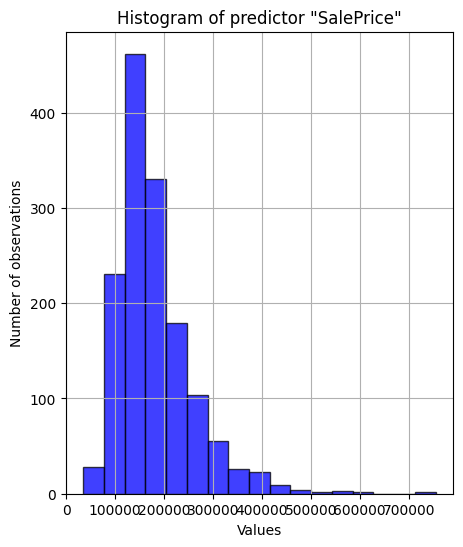

In [49]:
hcoe.d(train).pc('SalePrice')
hcoe.get_graph()

# Data transformations

In [50]:
col_target='SalePrice'
col_exclude=[
'Id',
col_target
]

## Categorical transformations

In [51]:
import category_encoders as ce

In [52]:
# potential predictors without encoding
cat_preds = [col for col in train.select_dtypes(include="object") if col not in col_exclude]
bool_preds = [col for col in train.select_dtypes(include="bool") if col not in col_exclude]
datetime_preds = [col for col in train.select_dtypes(include="datetime") if col not in col_exclude]

### Target Encoding

In [53]:
# # bayesian target encoding
# encoder = ce.TargetEncoder(min_samples_leaf=1, smoothing=1.0)
# encoder.fit_transform(train[cat_preds], train[col_target])

# train = pd.concat([train, encoder.transform(train[cat_preds]).add_prefix("BAYES_")], axis=1)
# test = pd.concat([test, encoder.transform(test[cat_preds]).add_prefix("BAYES_")], axis=1)

### One-Hot Encoding

In [54]:
encoder = ce.OneHotEncoder()
encoder.fit_transform(train[cat_preds], train[col_target])

train = pd.concat([train, encoder.transform(train[cat_preds]).add_prefix("ONEHOT_")], axis=1)
test = pd.concat([test, encoder.transform(test[cat_preds]).add_prefix("ONEHOT_")], axis=1)

In [55]:
col_preds=[col for col in train.select_dtypes(include=["int","float"]) if col!=col_target]

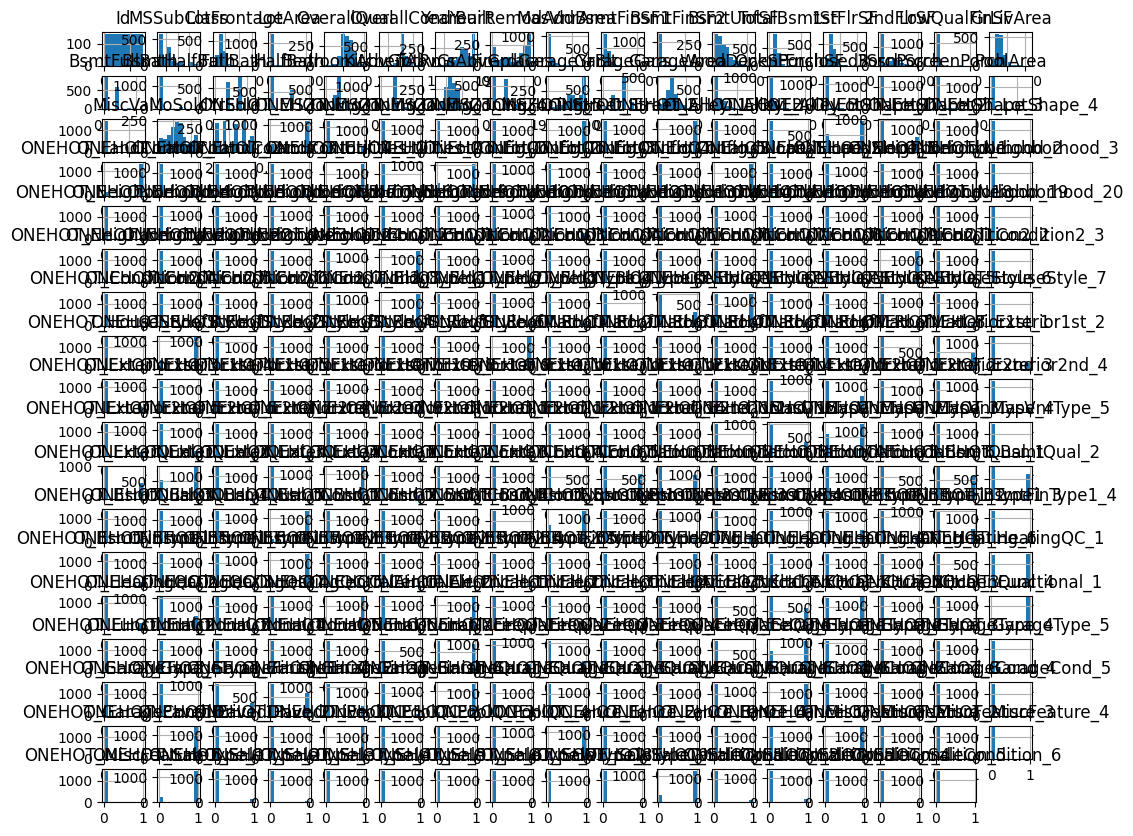

In [56]:
#showing the data
train[col_preds].hist(figsize = (12,10))
plt.show()

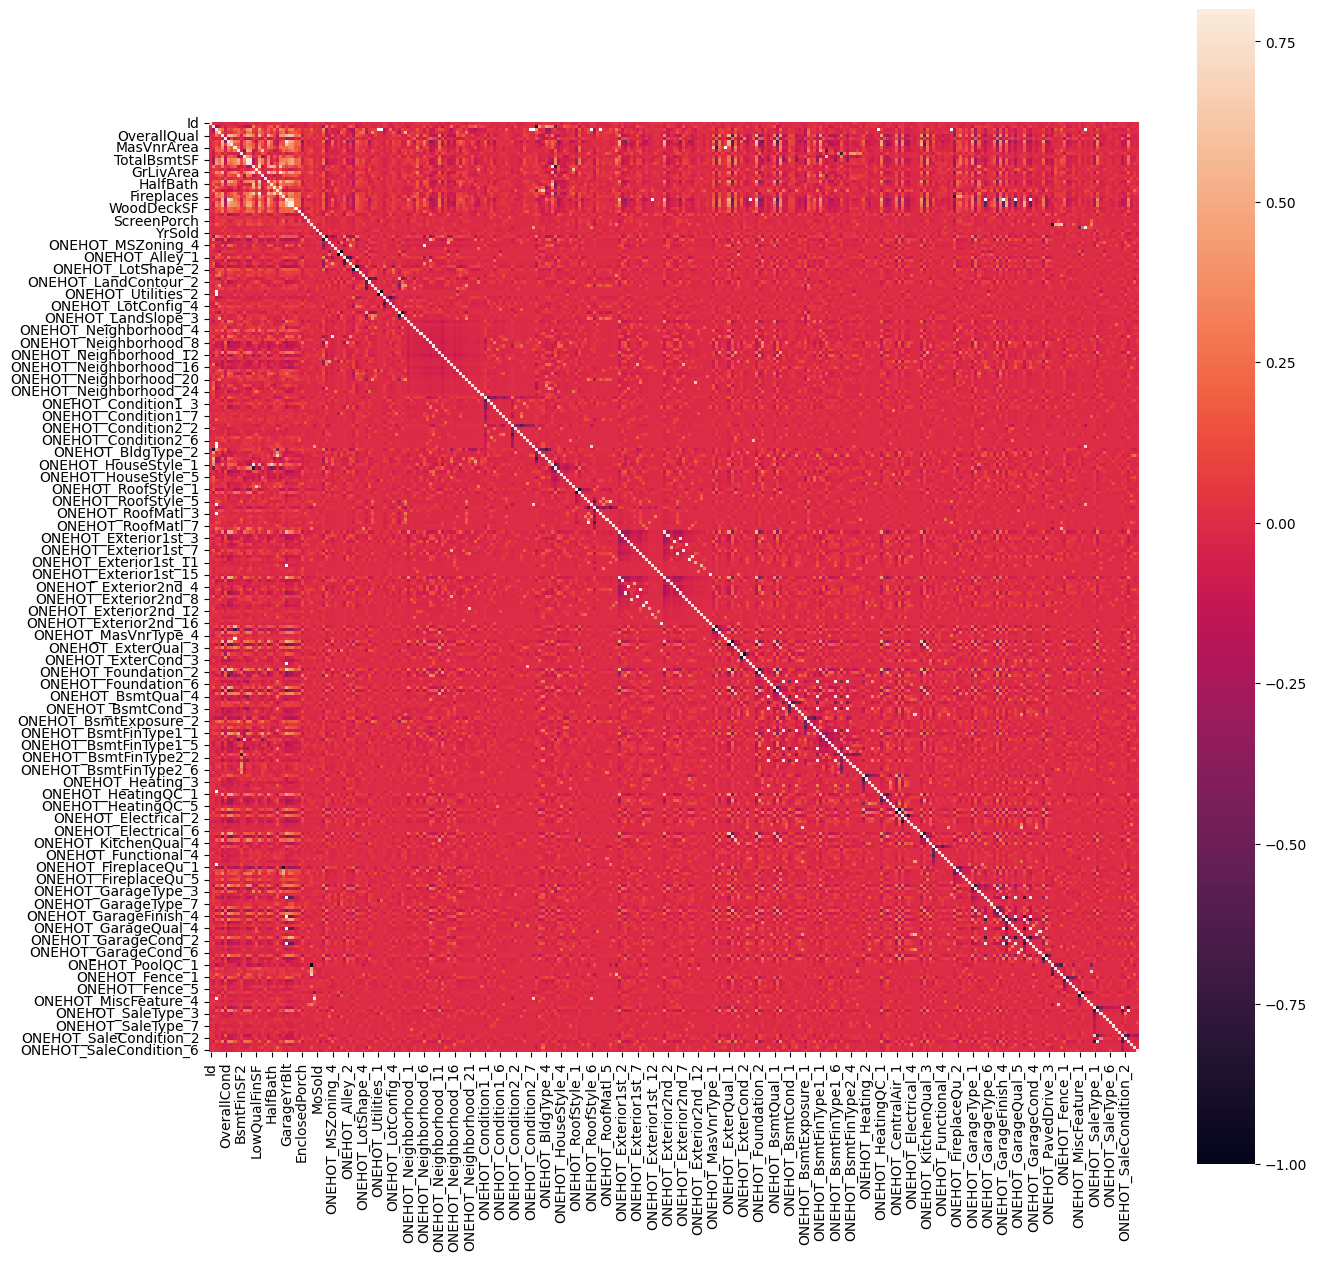

In [57]:
#correlations map
C_mat = train[col_preds].corr()
fig = plt.figure(figsize = (15,15))

sns.heatmap(C_mat, vmax = .8, square = True)
plt.show()

# Fitting models

## Neural network model

In [58]:
train = train.sample(frac=1,random_state=seed).reset_index(drop=True)

In [59]:
X_train, X_valid, y_train, y_valid= train_test_split(train, train[col_target], test_size=0.2, random_state=seed)

In [60]:
len(col_preds)

305

In [62]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=15, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = keras.Sequential([
    
    #layers.Dropout(rate=0.6), # apply 10% dropout to the next layer (to avoid overfitting)
    layers.Dense(units=512, input_shape=[len(col_preds)], activation='relu'),
    layers.BatchNormalization(), #instead of preprocessing with sklearn
    layers.Dropout(rate=0.8), # apply 80% dropout to the next layer (to avoid overfitting)
    layers.Dense(units=512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.8), # apply 80% dropout to the next layer (to avoid overfitting)
    layers.Dense(units=512, activation='relu'),
    layers.BatchNormalization(),
    # the linear output layer 
    layers.Dense(units=1), #activation='sigmoid' for binary problems
])

In [63]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               156672    
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)              

In [64]:
model.compile(
    optimizer='adam',
    loss='mean_squared_logarithmic_error', #change to 'mae' or 'mse' for regression problems
)

In [65]:
history = model.fit(
    X_train[col_preds].fillna(100), X_train[col_target].fillna(100),
    validation_data=(X_valid[col_preds].fillna(100), X_valid[col_target].fillna(100)),
    batch_size=100,
    #callbacks=[early_stopping], # put your callbacks in a list
    epochs=2500,
    verbose=0, # suppress output since we'll plot the curves
)

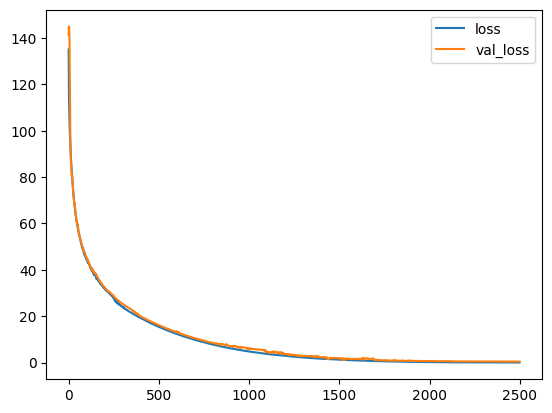

Minimum validation loss: 0.4170028865337372


In [66]:
#Validation loss develoment
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.show()
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [67]:
def relu_shifted(x):
    if x<34900:
        return 34900
    else:
        return x
       
X_train['NN_SCORE']=[x[0] for x in model.predict(X_train[col_preds].fillna(100))]
X_valid['NN_SCORE']=[x[0] for x in model.predict(X_valid[col_preds].fillna(100))]
train['NN_SCORE']=[x[0] for x in model.predict(train[col_preds].fillna(100))]
test['NN_SCORE']=[x[0] for x in model.predict(test[col_preds].fillna(100))]

X_train['NN_SCORE']=X_train['NN_SCORE'].apply(relu_shifted)
X_valid['NN_SCORE']=X_valid['NN_SCORE'].apply(relu_shifted)
train['NN_SCORE']=train['NN_SCORE'].apply(relu_shifted)
test['NN_SCORE']=test['NN_SCORE'].apply(relu_shifted)

In [68]:
# print('The Lift on the whole set is: '+ str(np.mean(whole_lifts)))
# print('The gini on the whole set is: '+ str(np.mean(whole_ginis)))
# print('\n')
print('The rmse on the train set is: '+ str(math.sqrt(mean_squared_log_error(X_train[col_target], X_train['NN_SCORE']))))
print('The rmse on the valid set is: '+ str(math.sqrt(mean_squared_log_error(X_valid[col_target], X_valid['NN_SCORE']))))
print('The rmse on the oot set is: '+ str(math.sqrt(mean_squared_log_error(train[col_target][1200:-1], train['NN_SCORE'][1200:-1]))))
print('\n')
print('The mae on the train set is: '+ str(mean_absolute_error(X_train[col_target], X_train['NN_SCORE'])))
print('The mae on the valid set is: '+ str(mean_absolute_error(X_valid[col_target], X_valid['NN_SCORE'])))
print('The mae on the oot set is: '+ str(mean_absolute_error(train[col_target][1200:-1], train['NN_SCORE'][1200:-1])))

The rmse on the train set is: 0.13917313818487406
The rmse on the valid set is: 0.18526017405132805
The rmse on the oot set is: 0.15162960002443762


The mae on the train set is: 19303.88314025043
The mae on the valid set is: 26569.92666416952
The mae on the oot set is: 21578.184815395754


In [69]:
train[['SalePrice', 'NN_SCORE']].head()

,SalePrice,NN_SCORE
0,205000.0,186648.765625
1,345000.0,305310.656250
2,173900.0,161331.750000
3,93500.0,94819.101562
4,265900.0,210409.312500


In [70]:
train['abs_diff']=np.abs(train['SalePrice']-train['NN_SCORE'])

In [71]:
train['abs_diff'].describe()

count    1.460000e+03
mean     2.075709e+04
std      5.987837e+04
min      2.125000e+01
25%      4.869930e+03
50%      1.136581e+04
75%      2.220806e+04
max      2.018839e+06
Name: abs_diff, dtype: float64

In [72]:
train[['SalePrice', 'NN_SCORE']].describe()

,SalePrice,NN_SCORE
count,1460.000000,1.460000e+03
mean,180921.195890,1.706687e+05
std,79442.502883,8.033985e+04
min,34900.000000,3.490000e+04
25%,129975.000000,1.319176e+05
50%,163000.000000,1.549299e+05
75%,214000.000000,1.962515e+05
max,755000.000000,2.393839e+06


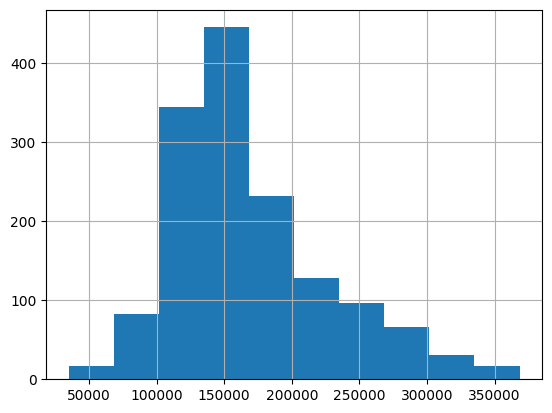

In [73]:
test['NN_SCORE'].hist()
plt.show()

In [74]:
test['SalePrice']=test['NN_SCORE']

In [76]:
test[['Id', 'SalePrice']].to_csv('/kaggle/working/Prediction_nn.csv', index=False)